# Convergence tests for right-hand side (rhs) of problem definitions

In [1]:
import voxelsss as vox
import numpy as np
from numpy import sin, cos, pi
import torch
import matplotlib.pyplot as plt

### Define generic convergence test

We use the discrete $L_2$–norm of the difference divided by the $L_2$–norm of the exact solution, i.e. a relative $L_2$ error to quantify convergence of spatial discretization.

In [2]:
def rhs_convergence_test(
    ODE_class,       # an ODE class with callable rhs(field, t)->torch.Tensor (shape [x,y,z])
    problem_kwargs,  # problem parameters to instantiate ODE
    init_fun,        # exact init_fun(x,y,z)->np.ndarray
    exact_fun,       # exact_fun(x,y,z)->np.ndarray
    convention='cell_center',
    dtype='float32',
    powers = np.array([3,4,5,6,7]),
    backend = 'torch'
):
    dx     = np.zeros(len(powers))
    errors = np.zeros(len(powers))

    for i, p in enumerate(powers):
        if convention == 'cell_center':
            vf = vox.VoxelFields(2**p, 2**p, 2**p, (1,1,1), convention=convention)
        elif convention == 'staggered_x':
            vf = vox.VoxelFields(2**p+1, 2**p, 2**p, (1,1,1), convention=convention)
        vf.precision = dtype
        grid = vf.meshgrid()
        init_data = init_fun(*grid)

        if backend == 'torch':
            vg = vox.voxelgrid.VoxelGridTorch(vf.grid_info(), precision=vf.precision, device='cpu')
        elif backend == 'jax':
            vg = vox.voxelgrid.VoxelGridJax(vf.grid_info(), precision=vf.precision)
        field = vg.init_field_from_numpy(init_data)
        ODE = ODE_class(vg, **problem_kwargs)

        # Compute solutions
        result = ODE.rhs(field, 0)
        comp = vg.export_field_to_numpy(result)
        exact = exact_fun(*grid)
        if convention == 'staggered_x':
            comp = comp[1:-1,:,:]
            exact = exact[1:-1,:,:]
            # @SIMON: is this a problem now that we dont have ghost nodes?

        # Error norm
        diff = comp - exact
        errors[i] = np.linalg.norm(diff)/np.linalg.norm(exact)
        dx[i]     = vf.spacing[0]

    return dx, errors

### Test rhs Cahn-PeriodicCahnHilliard: Compute div( c*(1-c)*grad(mu) )

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors:       [0.09942681 0.02579302 0.00650897 0.00163107 0.00040801]
Convergence rate from slope fit: 1.9840871245417449


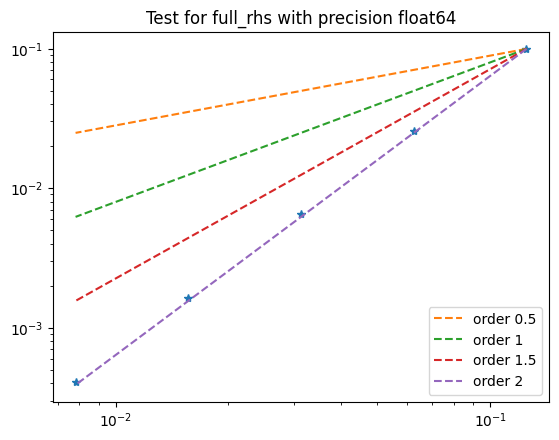

In [3]:
from voxelsss.problem_definition import PeriodicCahnHilliard
alpha = 0.4
beta = 0.1

def init_fun(x,y,z):
    return  alpha + beta*sin(2*pi*x)
    
def result_fun(x,y,z):
    return pi**2*beta*(-2*beta*(alpha + beta*sin(2*pi*x))*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 - 2*beta*(alpha + beta*sin(2*pi*x) - 1)*(72.0*alpha**2 + 144.0*alpha*beta*sin(2*pi*x) - 72.0*alpha - 72.0*beta**2*(1 - cos(2*pi*x))**2 - 144.0*beta**2*cos(2*pi*x) + 144.0*beta**2 - 72.0*beta*sin(2*pi*x) + 12.0 + 48.0*pi**2)*cos(2*pi*x)**2 + (alpha + beta*sin(2*pi*x))*(alpha + beta*sin(2*pi*x) - 1)*(144.0*alpha**2*sin(2*pi*x) - 576.0*alpha*beta*(1 - cos(2*pi*x))**2 - 1152.0*alpha*beta*cos(2*pi*x) + 864.0*alpha*beta - 144.0*alpha*sin(2*pi*x) - 432.0*beta**2*(1 - cos(2*pi*x))**2*sin(2*pi*x) + 576.0*beta**2*sin(2*pi*x) - 432.0*beta**2*sin(4*pi*x) + 288.0*beta*(1 - cos(2*pi*x))**2 + 576.0*beta*cos(2*pi*x) - 432.0*beta + 24.0*sin(2*pi*x) + 96.0*pi**2*sin(2*pi*x)))

precision = 'float64'
dx, errors = rhs_convergence_test(
        ODE_class      = PeriodicCahnHilliard,
        problem_kwargs = {'eps': 3.0, 'D': 1.0, 'A': 0.25},
        init_fun       = init_fun,
        exact_fun      = result_fun,
        convention     = 'cell_center',
        dtype          = precision
    )

print(f"Grid spacing: {dx}")
print(f"Errors:       {errors}")
slope, _ = np.polyfit(np.log(dx), np.log(errors), 1)
print("Convergence rate from slope fit:", slope)

plt.loglog(dx, errors,'*')
plt.loglog(dx, errors[0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()


This test shows that for fourth order spatial gradients based on a finite difference scheme, single precision is not sufficient for small dx.